In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("S&P 500 Stock Analysis") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

In [ ]:
# Load the CSV data into a Spark DataFrame
stocks_df = spark.read.csv(
    "data/all_stocks_5yr.csv",  # Path to your dataset file
    header=True,                # Use the first row as column headers
    inferSchema=True            # Automatically detect data types of columns
)

# Show the schema (structure and data types) of the DataFrame
stocks_df.printSchema()

# Display the first 5 rows to verify data loaded correctly
stocks_df.show(5)

In [10]:
# Count total rows in the DataFrame
total_records = stocks_df.count()
print(f"Total records: {total_records}")

# Count unique company tickers in the 'Name' column
distinct_tickers = stocks_df.select("Name").distinct().count()
print(f"Number of unique companies (tickers): {distinct_tickers}")

# Show summary statistics (count, mean, stddev, min, max) for 'close' prices
stocks_df.describe("close").show()

Total records: 619040
Number of unique companies (tickers): 505
+-------+-----------------+
|summary|            close|
+-------+-----------------+
|  count|           619040|
|   mean|83.04376276476519|
| stddev|97.38974800165782|
|    min|             1.59|
|    max|           2049.0|
+-------+-----------------+



In [18]:
# Import the year function from pyspark.sql.functions
from pyspark.sql.functions import col, year, month, dayofmonth, avg, stddev

# Extract distinct years from the 'date' column and order them ascending
years = stocks_df.select(year("date").alias("Year")).distinct().orderBy("Year")

# Show the years
years.show()

+----+
|Year|
+----+
|2013|
|2014|
|2015|
|2016|
|2017|
|2018|
+----+



In [12]:
# Remove any rows with null values from the DataFrame
clean_df = stocks_df.dropna()

# Show the first 5 rows of the cleaned data to verify
clean_df.show(5)

+----------+-----+-----+-----+-----+--------+----+
|      date| open| high|  low|close|  volume|Name|
+----------+-----+-----+-----+-----+--------+----+
|2013-02-08|15.07|15.12|14.63|14.75| 8407500| AAL|
|2013-02-11|14.89|15.01|14.26|14.46| 8882000| AAL|
|2013-02-12|14.45|14.51| 14.1|14.27| 8126000| AAL|
|2013-02-13| 14.3|14.94|14.25|14.66|10259500| AAL|
|2013-02-14|14.94|14.96|13.16|13.99|31879900| AAL|
+----------+-----+-----+-----+-----+--------+----+
only showing top 5 rows


In [19]:
# Extract year, month, and day from the 'date' column to new columns
from pyspark.sql.functions import year, month, dayofmonth

clean_df = clean_df.withColumn("year", year(col("date"))) \
                   .withColumn("month", month(col("date"))) \
                   .withColumn("day", dayofmonth(col("date")))

# Show a few rows to confirm the new columns are added
clean_df.select("date", "year", "month", "day").show(5)

# Calculate average closing price per year to see long-term trends
avg_close_per_year = clean_df.groupBy("year") \
                             .agg(avg("close").alias("avg_close")) \
                             .orderBy("year")

# Show the average closing price per year
avg_close_per_year.show()

# Calculate volatility (standard deviation of close price) per year
volatility_per_year = clean_df.groupBy("year") \
                              .agg(stddev("close").alias("volatility")) \
                              .orderBy("year")

volatility_per_year.show()

+----------+----+-----+---+
|      date|year|month|day|
+----------+----+-----+---+
|2013-02-08|2013|    2|  8|
|2013-02-11|2013|    2| 11|
|2013-02-12|2013|    2| 12|
|2013-02-13|2013|    2| 13|
|2013-02-14|2013|    2| 14|
+----------+----+-----+---+
only showing top 5 rows
+----+------------------+
|year|         avg_close|
+----+------------------+
|2013|  64.3686189813534|
|2014| 76.96983632033465|
|2015| 84.13155804887118|
|2016| 85.25396450925628|
|2017| 98.80054751846778|
|2018|111.28763130236096|
+----+------------------+

+----+------------------+
|year|        volatility|
+----+------------------+
|2013|62.964690192406415|
|2014| 82.18660333922418|
|2015| 92.83626361938182|
|2016|100.40549255142344|
|2017|123.89896306619966|
|2018|142.19364604419218|
+----+------------------+



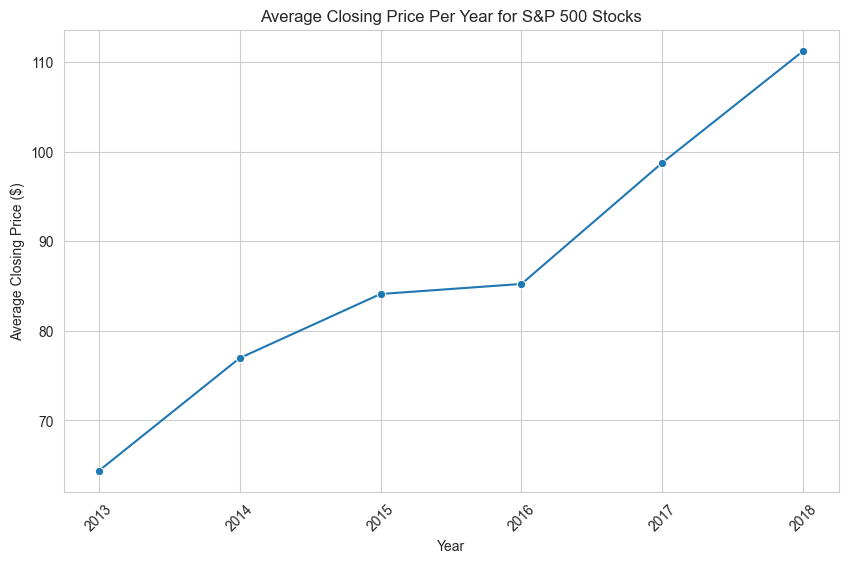

In [21]:
# Step 1: Convert PySpark DataFrame to pandas DataFrame
avg_close_pd = avg_close_per_year.toPandas()

# Step 2: Import seaborn and matplotlib for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Step 3: Set a seaborn style for nicer visuals
sns.set_style("whitegrid")

# Step 4: Create a line plot with seaborn
plt.figure(figsize=(10,6))
sns.lineplot(data=avg_close_pd, x='year', y='avg_close', marker='o')

# Step 5: Add titles and labels for clarity
plt.title('Average Closing Price Per Year for S&P 500 Stocks')
plt.xlabel('Year')
plt.ylabel('Average Closing Price ($)')
plt.xticks(rotation=45) 

# Step 6: Show the plot
plt.show()

In [24]:
# Group the cleaned stock data by year
# Then calculate the standard deviation (volatility) of the 'close' price
# This gives a sense of how much prices fluctuated each year
volatility_df = clean_df.groupBy("year") \
    .agg(stddev("close").alias("volatility")) \
    .orderBy("year")  # Sort the result by year for easier plotting

In [25]:
# Convert the PySpark DataFrame to a Pandas DataFrame
# so we can use Seaborn and Matplotlib to plot
volatility_pd = volatility_df.toPandas()

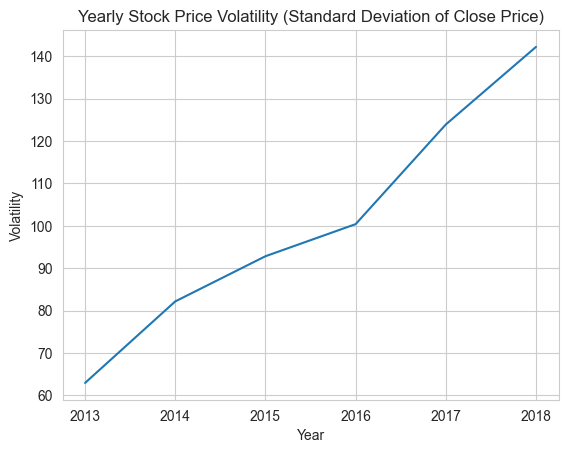

In [26]:
# Create a line plot of volatility over the years
# This helps visualize which years had the most market uncertainty
sns.lineplot(data=volatility_pd, x="year", y="volatility")

# Add axis labels and a chart title for clarity
plt.title("Yearly Stock Price Volatility (Standard Deviation of Close Price)")
plt.xlabel("Year")
plt.ylabel("Volatility")
plt.show()

In [27]:
# Sample 10% of the dataset to keep the boxplot readable
# (especially useful with 600k+ rows)
sampled_df = clean_df.sample(fraction=0.1, seed=42)

In [28]:
# Convert to Pandas for visualization
sampled_pd = sampled_df.select("year", "close").toPandas()

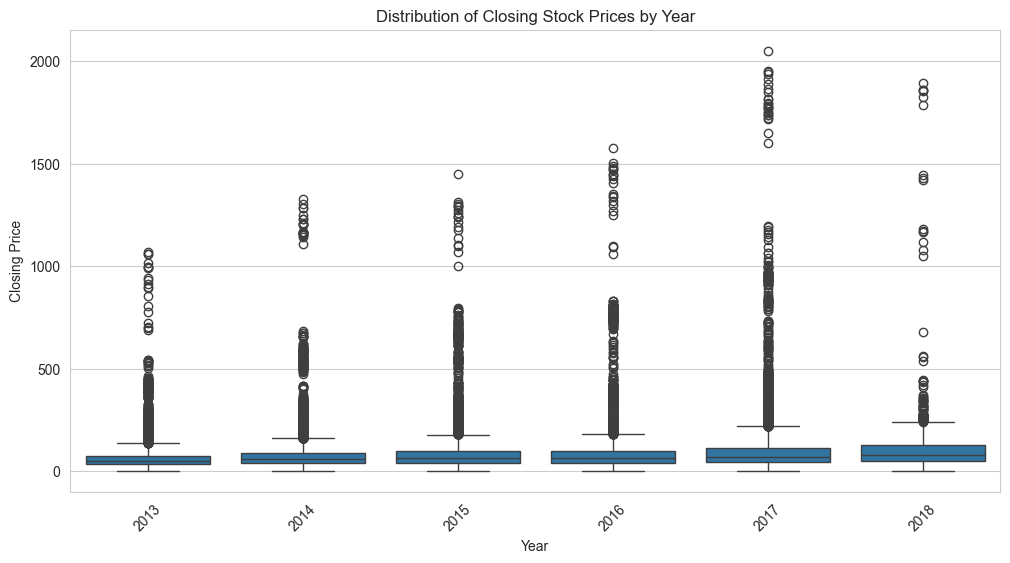

In [29]:
# Create a boxplot to show distribution of close prices per year
# This reveals the spread, median, and outliers per year
plt.figure(figsize=(12, 6))
sns.boxplot(data=sampled_pd, x="year", y="close")

# Label the chart
plt.title("Distribution of Closing Stock Prices by Year")
plt.xlabel("Year")
plt.ylabel("Closing Price")
plt.xticks(rotation=45)
plt.show()

In [30]:
# Group by year and month, calculating average closing price
monthly_avg_df = clean_df.groupBy("year", "month") \
                         .agg(avg("close").alias("avg_close")) \
                         .orderBy("year", "month")

In [31]:
# Convert to Pandas for heatmap formatting
monthly_avg_pd = monthly_avg_df.toPandas()

# Create a pivot table with years as rows, months as columns
pivot_table = monthly_avg_pd.pivot(index="year", columns="month", values="avg_close")

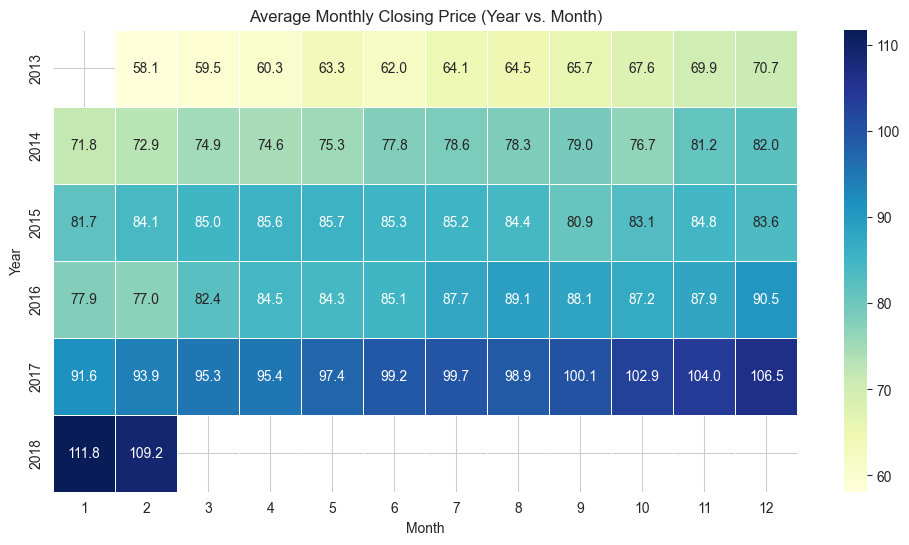

In [59]:
# Set figure size and plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, fmt=".1f", linewidths=0.5)

# Label the heatmap
plt.title("Average Monthly Closing Price (Year vs. Month)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

In [60]:
from pyspark.sql.functions import avg

# Calculate average close per company per year
avg_close_by_company_year = clean_df.groupBy("Name", "year") \
    .agg(avg("close").alias("avg_close"))

# Top 10 highest average yearly performers
top_performers = avg_close_by_company_year.orderBy("avg_close", ascending=False).limit(10)
top_performers.show()

# Bottom 10 lowest average yearly performers
bottom_performers = avg_close_by_company_year.orderBy("avg_close").limit(10)
bottom_performers.show()

+-----+----+------------------+
| Name|year|         avg_close|
+-----+----+------------------+
| PCLN|2018|1891.3642307692314|
| PCLN|2017|1798.1545418326689|
| PCLN|2016|1346.7126984126985|
| AMZN|2018|1329.1846153846152|
| PCLN|2015|1219.8809523809523|
| PCLN|2014| 1197.960952380953|
|GOOGL|2018|1131.9346153846154|
| GOOG|2018|1123.4907692307693|
| AMZN|2017| 968.1513944223107|
|GOOGL|2017| 939.7733864541834|
+-----+----+------------------+

+----+----+------------------+
|Name|year|         avg_close|
+----+----+------------------+
| AMD|2015| 2.331765873015873|
| AMD|2013| 3.463584070796459|
| AMD|2014| 3.662063492063491|
| CHK|2018|3.8407692307692303|
| CHK|2017| 4.901633466135456|
| CHK|2016| 5.173531746031743|
| AMD|2016| 5.254781746031745|
|HBAN|2013| 8.135721238938054|
|  RF|2013| 9.171836283185838|
|HBAN|2014| 9.669657936507933|
+----+----+------------------+



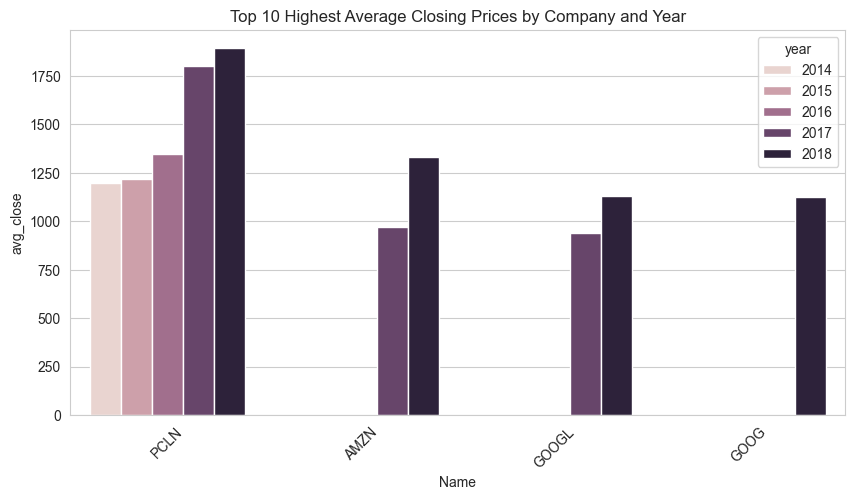

In [61]:
top_pd = top_performers.toPandas()
bottom_pd = bottom_performers.toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=top_pd, x="Name", y="avg_close", hue="year")
plt.title("Top 10 Highest Average Closing Prices by Company and Year")
plt.xticks(rotation=45)
plt.show()

In [62]:
from pyspark.sql.functions import col, avg, stddev

# Filter the dataset to only include the years 2015 and 2016
# These years saw increased market volatility, so they’re a useful stand-in for crisis periods
crash_period_df = clean_df.filter((col("year") == 2015) | (col("year") == 2016))

# Group the filtered data by year and calculate:
# - average 'close' price (to understand general performance)
# - standard deviation of 'close' (to measure volatility)
crash_analysis = crash_period_df.groupBy("year") \
    .agg(
        avg("close").alias("avg_close"),         # average closing price per year
        stddev("close").alias("volatility")      # volatility of closing price per year
    ) \
    .orderBy("year")  # sort results chronologically

# Display the results: average prices and volatility for each year
crash_analysis.show()

+----+-----------------+------------------+
|year|        avg_close|        volatility|
+----+-----------------+------------------+
|2015|84.13155804887118| 92.83626361938182|
|2016|85.25396450925628|100.40549255142344|
+----+-----------------+------------------+



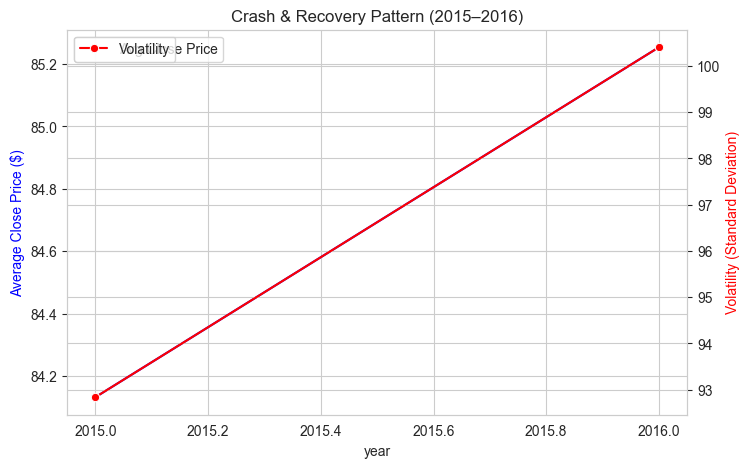

In [63]:
# Convert Spark DataFrame to Pandas for plotting
crash_pd = crash_analysis.toPandas()

# Plot average closing price and volatility for 2015 and 2016
import matplotlib.pyplot as plt
import seaborn as sns

# Line plot for both metrics
fig, ax1 = plt.subplots(figsize=(8,5))

# Plot avg_close on primary Y-axis
sns.lineplot(data=crash_pd, x="year", y="avg_close", marker='o', ax=ax1, label="Avg Close Price", color='blue')
ax1.set_ylabel("Average Close Price ($)", color='blue')

# Create a secondary Y-axis for volatility
ax2 = ax1.twinx()
sns.lineplot(data=crash_pd, x="year", y="volatility", marker='o', ax=ax2, label="Volatility", color='red')
ax2.set_ylabel("Volatility (Standard Deviation)", color='red')

# Title and display
plt.title("Crash & Recovery Pattern (2015–2016)")
plt.show()

+-----+-----------------+
|month|        avg_close|
+-----+-----------------+
|    1|87.34745431048299|
|    2|80.06392394162754|
|    3|80.16524429420903|
|    4|79.81100336413687|
|    5|81.35084310261792|
|    6|82.48267044008385|
|    7|82.84415970836521|
|    8|83.45794629609107|
|    9|82.94995480259392|
|   10|83.41413878062151|
|   11|85.98498061300228|
|   12|86.57080837902372|
+-----+-----------------+



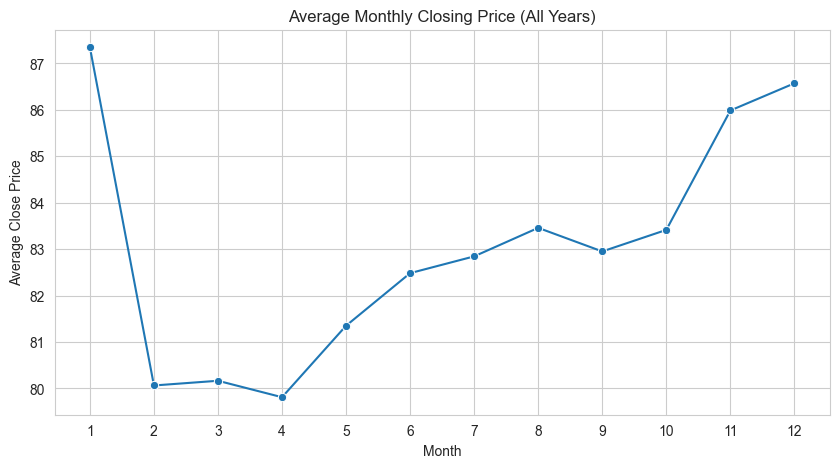

In [64]:
# Average close price per month across all years
monthly_avg_close = clean_df.groupBy("month") \
    .agg(avg("close").alias("avg_close")) \
    .orderBy("month")

monthly_avg_close.show()

# Visualize with Seaborn
monthly_pd = monthly_avg_close.toPandas()

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_pd, x="month", y="avg_close", marker='o')
plt.title("Average Monthly Closing Price (All Years)")
plt.xlabel("Month")
plt.ylabel("Average Close Price")
plt.xticks(range(1, 13))
plt.show()